In [ ]:
!pip install monai
!pip install torchmetrics
!pip install segmentation_models_pytorch

In [35]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/dl final\ project\ 3
root_dir = "/content/drive/MyDrive/dl final project 3"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/dl final project 3


In [36]:
import os
import pickle
import segmentation_models_pytorch as smp
from monai.data import DataLoader, Dataset
from monai.utils import set_determinism
import torch
from torchmetrics import JaccardIndex
from tqdm import tqdm
from transformers import SegformerConfig, SegformerForSemanticSegmentation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


from custom_model import CustomModel

warnings.filterwarnings('ignore')


### Load preprocessed data

In [37]:
# make sure those files exist before running this cell
with open(os.path.join(root_dir, 'kfold_splits.pkl'), 'rb') as f:
    folds = pickle.load(f)
with open(os.path.join(root_dir, 'test_set.pkl'), 'rb') as f:
    test_set = pickle.load(f)


### Define training function

In [38]:
def get_model(model_type, device, attention_gate_flag=False):
    if model_type == "resnet":
        # Create the UNet model with the specified backbone
        model = smp.Unet(
            encoder_name="resnet34",
            in_channels=3,
            classes=1,
            activation="sigmoid",
            encoder_weights=None
        ).to(device)
    elif model_type == "unet":
        model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=False).to(device)
    elif model_type == "segformer":
        config = SegformerConfig(num_labels=1)
        model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512", num_labels=1, ignore_mismatched_sizes=True).to(device)
    elif model_type == "custom":
        model = CustomModel(
            channels = [64, 128, 256, 512],
            scale = [4, 2, 2, 2],
            num_blocks = [2, 2, 2, 2],
            num_heads = [2, 4, 8, 16],
            mlp_hidden = [256, 512, 1024, 2048],
            dropout = 0.2,                     # change to dropout rate=0.2
            decoder_hidden = 256,
            attention=attention_gate_flag, # whether to use attention gate
        ).to(device)

    return model


### Training

In [39]:
gpu = "cuda"
gpu = "cpu"
loss = "Jaccard"

In [40]:
if gpu == "cuda":
    device = torch.device("cuda:0")
elif gpu == "cpu":
    device = torch.device("cpu")

if loss == "Dice":
    loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)
elif loss == "Jaccard":
    loss_function = smp.losses.JaccardLoss(mode="binary", from_logits=False)

metric = JaccardIndex(task="binary").to(device)

In [41]:
loss_function, metric

(JaccardLoss(), BinaryJaccardIndex())

In [43]:
set_determinism(0)

Load Model and Visualize Attention

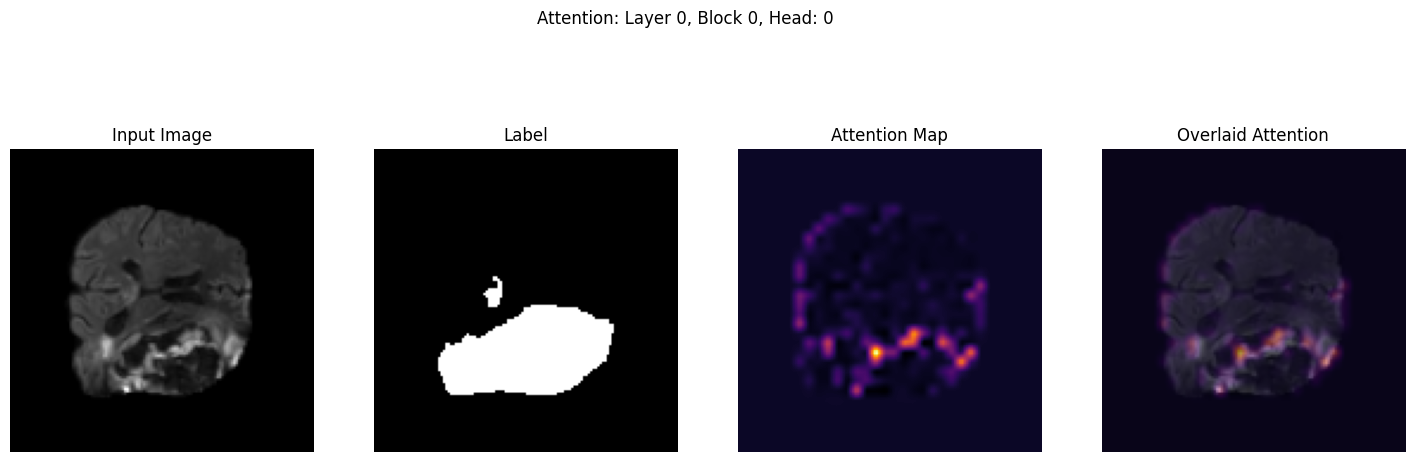

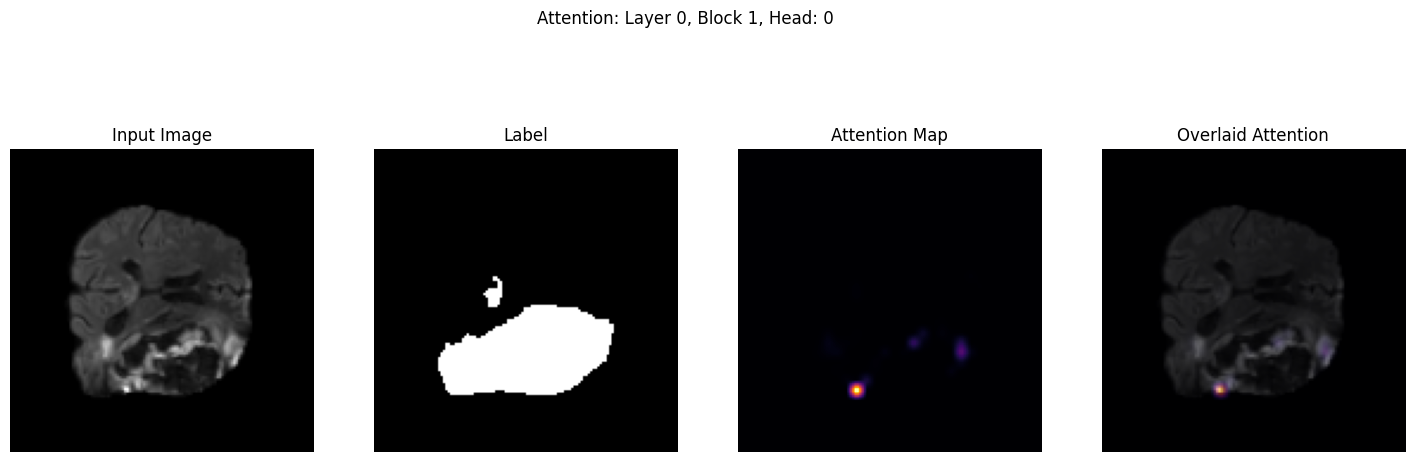

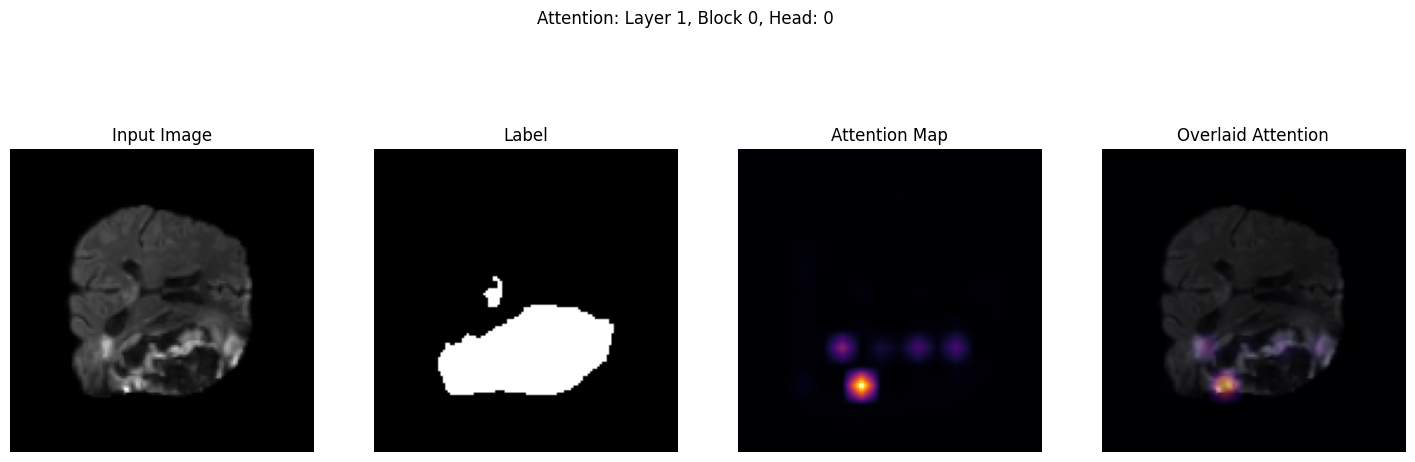

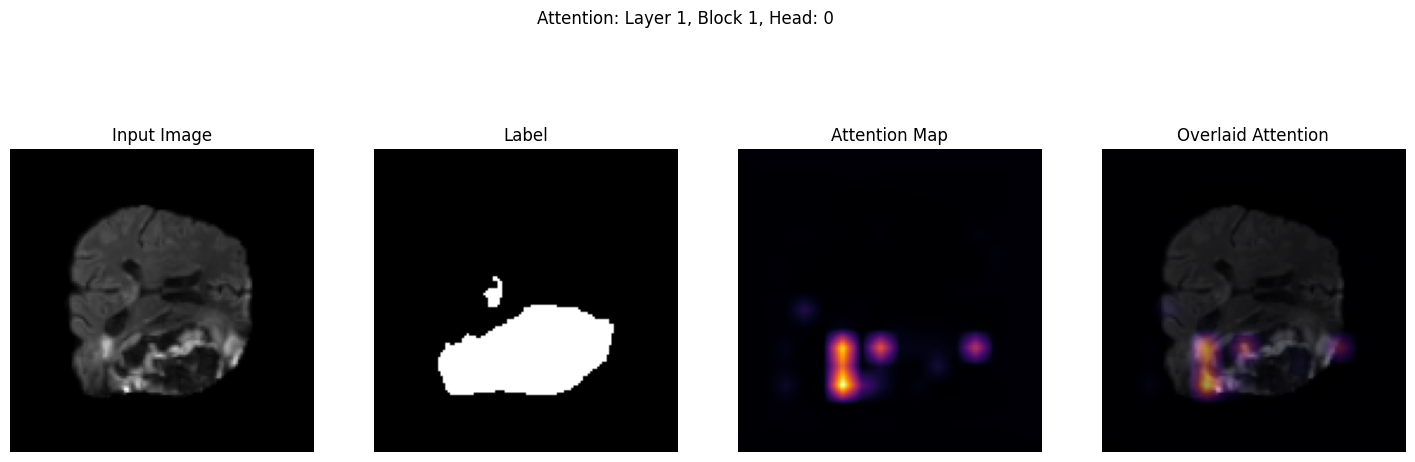

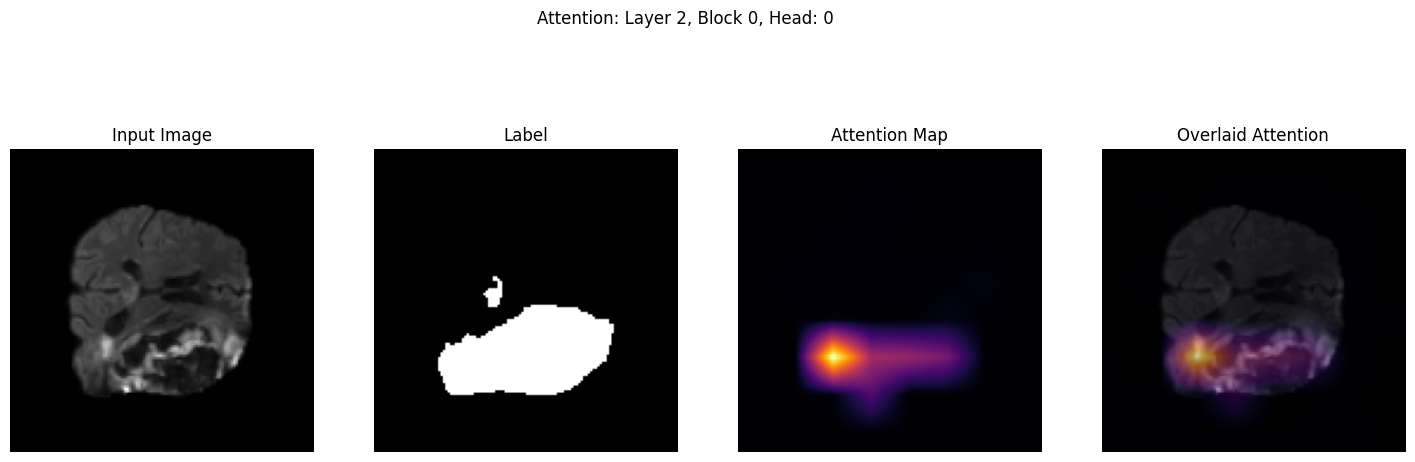

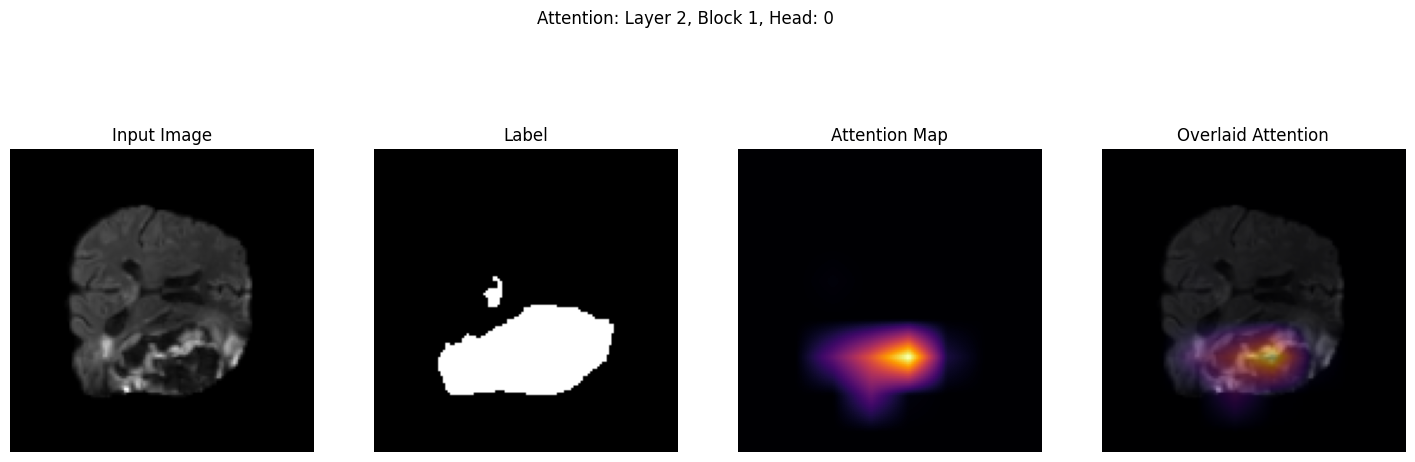

In [48]:
model_type = "custom"
out_dir = os.path.join(root_dir, model_type)

test_loader = DataLoader(
    test_set, batch_size=8, num_workers=4
)

model = get_model(model_type, device, attention_gate_flag=True)

if gpu == "cuda":
    model.load_state_dict(torch.load(os.path.join(root_dir, model_type, "best_metric_model.pth")))
elif gpu == "cpu":
    model.load_state_dict(torch.load(os.path.join(root_dir, model_type, "best_metric_model.pth"), map_location=torch.device('cpu')))

model.eval()

# Function to attach a hook and capture attention weights
def attention_hook(module, input, output):
    global attention_weights
    # output is a tuple of (output, attn_weights), where attn_weights is what we need
    attention_weights = output[1].detach()  # Detach to avoid any gradient computation

# Attach the hook to the first self-attention block of the first transformer in the first encoder layer

for layer in range(3):
     for block in range(2):

        handle = model.encoder.layers[layer]['transformers'].blocks[block]['self-attention'].attention.register_forward_hook(attention_hook)
        plt.figure(figsize=(18, 6))  # Adjust the figure size as needed

        with torch.no_grad():
            for i, test_data in enumerate(test_loader):
                if i != 103:
                    continue

                img_index = 1

                test_outputs = model(test_data["image"].to(device))
                test_labels = test_data["label"].to(device)

                attention_map = attention_weights[img_index][0]  # First head's attention weights of the first example
                attention_map = attention_map.cpu()  # Move the attention map to CPU
                # Reshape the attention map to its square form if it's flat (assuming it's a square matrix)
                side_length = int(attention_map.shape[0] ** 0.5)
                attention_map = attention_map.view(side_length, side_length)
                attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

                plt.suptitle(f"Attention: Layer {layer}, Block {block}, Head: 0")

                # Plot original image
                img = test_data["image"][img_index].cpu().numpy().transpose(1, 2, 0)
                img = (img - img.min()) / (img.max() - img.min())  # Normalize image for displaying
                plt.subplot(1, 4, 1)
                plt.imshow(img)
                plt.title("Input Image")
                plt.axis("off")

                # Plot labeled image
                label_img = test_data["label"][img_index].cpu().numpy().squeeze()
                plt.subplot(1, 4, 2)
                plt.imshow(label_img, cmap='gray')
                plt.title("Label")
                plt.axis("off")

                # Plot attention image
                plt.subplot(1, 4, 3)
                attention_map_np = attention_map.numpy()
                attention_map_np = cv2.resize(attention_map.numpy(), (128, 128))
                plt.imshow(attention_map_np, cmap="inferno")
                plt.title("Attention Map")
                plt.axis("off")
                # plt.colorbar()

                # Plot attention image overlayed on original image
                plt.subplot(1, 4, 4)
                input_image = img.copy()
                input_image = input_image[:, :, 0]

                # select a colormap from matplotlib
                colormap = plt.get_cmap('inferno')

                # Create overlay image from attention_map
                attention_map_overlay = attention_map_np.copy()
                attention_map_overlay = (colormap(attention_map_overlay) * 255).astype(np.uint8)
                attention_map_overlay = attention_map_overlay[:, :, :3]

                # Convert input image to three channels (to match attention_map_overlay dimensions)
                # Also convert scale to 0-255
                input_image_bgr = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR) * 255

                # Combine both original image and overlay image
                overlay_weight = 0.5
                final_image = attention_map_overlay * overlay_weight + input_image_bgr * (1 - overlay_weight)
                final_image = final_image.astype(np.uint8)

                # Display images
                plt.imshow(final_image)
                plt.axis("off")
                plt.title("Overlaid Attention")

                file_name = f"Attention: Layer {layer}, Block {block}, Head: 0.png"
                plt.savefig(os.path.join(root_dir, model_type, "images", file_name))

                plt.show()
                break

plt.show()
handle.remove()  # Clean up the hook after use to prevent memory leak
